In [598]:
"""Train 3 neural networks to obtain a prediction interval for the data."""

import dataclasses as dc
import time
from pathlib import Path
from typing import Literal, Optional, TypeVar, Callable

import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy import optimize

import utils
import utils.commandline
from utils.files import MySmartFile, MySmartFolder, MyDir, load_json, save_json

BLOCK = False
T = TypeVar("T")


@dc.dataclass
class TrainingParams:
    max_epochs: int = 1000
    initial_learning_rate: float = 0.05
    batch_size: Optional[int] = 32  # if None, batch size equals dataset size
    activation: str = "tanh"
    loss_fun: str = "mse"
    optimizer: str = "adam"
    learning_rate_schedule: str = "constant"  # TODO: unused
    validation_fraction: float = 0.2
    stop_early: bool = True
    n_neurons_per_layer: list[int] = dc.field(default_factory=lambda: [64])


@dc.dataclass
class ExperimentParams:
    # TODO: Check that each param is used
    out_dir: Path
    x_data_path: Path
    y_data_path: Path
    quantiles: list[float] = dc.field(default_factory=lambda: [0.95, 0.9, 0.85, 0.8])
    seed: int = dc.field(default_factory=lambda: time.time_ns() % 10**9)
    debug: bool = False
    visualize: bool = True
    load_checkpoint: bool = True
    positivity_method: str = "sqrt_sqr"
    verbose: int = 1


def read_commandline():
    parser = utils.commandline.parser_from_dataclasses(
        [ExperimentParams, TrainingParams, TrainingParams],
        postfixes=["", "_mean", "_std"],
        positional_args={"out_dir", "x_data_path", "y_data_path"},
    )
    clargs = vars(parser.parse_args())
    params = (
        utils.commandline.dict_to_dataclass(TrainingParams, clargs, consume=True),
        utils.commandline.dict_to_dataclass(ExperimentParams, clargs, consume=True),
    )
    assert len(clargs) == 0
    return params


def preprocess_data(arr: np.ndarray) -> np.ndarray:
    arr = np.squeeze(arr)
    if arr.ndim > 2:
        raise ValueError(f"Too many dimensions: {arr.shape}")

    if arr.ndim == 1:
        return arr[:, np.newaxis]

    assert arr.ndim == 2

    return arr


def make_model(layer_sizes: list[int], activation, normalizer, positivity_method=None):
    model = keras.Sequential(
        [
            keras.Input(shape=(layer_sizes[0],)),
            normalizer,
            # keras.layers.LayerNormalization(),
            keras.layers.BatchNormalization(),
            *[keras.layers.Dense(n, activation=activation) for n in layer_sizes[1:-1]],
            keras.layers.Dense(layer_sizes[-1]),
        ]
    )

    if positivity_method:
        x = model(model.inputs)
        x = {
            "sqrt_sqr": lambda: keras.ops.sqrt(keras.ops.square(x) + 1e-8),  # type: ignore
            "abs": lambda: keras.ops.abs(x),
            "relu": lambda: keras.layers.ReLU()(x),  # bad option
            "softplus": lambda: keras.layers.Activation("softplus")(x),
            "exp": lambda: keras.layers.Activation("exponential")(x),
        }.get(
            positivity_method,
            lambda: ValueError(f"Unknown positivity method: {positivity_method}"),
        )()
        model = keras.Model(model.input, x)

    return model


@dc.dataclass
class TrainingResult:
    model: keras.Model
    x_train: np.ndarray
    y_train: np.ndarray
    x_eval: np.ndarray
    y_eval_pred: np.ndarray
    y_train_pred: np.ndarray

    @property
    def can_plot(self):
        return self.x_train.shape[1] == 1 and self.y_train.shape[1] == 1

    def plot(self, title: str):
        if not self.can_plot:
            return
        plt.figure()
        plt.title(title)
        plt.scatter(self.x_train, self.y_train, alpha=0.5)
        plt.plot(self.x_eval, self.y_eval_pred, "k-", lw=3)


def train_model(
    model,
    x_train,
    y_train,
    x_eval,
    training_params: TrainingParams,
    experiment_params: ExperimentParams,
    model_type: Literal["mean", "std"],
) -> TrainingResult:
    if isinstance(model, keras.Model):
        # reduce_lr = keras.callbacks.ReduceLROnPlateau(
        #     monitor="val_loss",
        #     factor=0.1,
        #     patience=10,
        #     min_lr=training_params.get_initial_learning_rate(model_type) / 100,
        # )
        scheduler = keras.optimizers.schedules.ExponentialDecay(
            training_params.get_initial_learning_rate(model_type),
            decay_steps=200,
            decay_rate=0.7,
            staircase=True,
        )
        reduce_lr = keras.callbacks.LearningRateScheduler(
            schedule=lambda i: float(scheduler(i)),
            verbose=0,
        )

        if experiment_params.debug:
            print("Warning: Running eagerly is slow!")
        model.compile(
            loss=training_params.get_loss(model_type),
            optimizer=keras.optimizers.get(
                {
                    "class_name": training_params.optimizer,  # type: ignore
                    "config": {
                        # "learning_rate": lr_schedule
                        "learning_rate": training_params.get_initial_learning_rate(
                            model_type
                        )
                    },
                }
            ),
            run_eagerly=experiment_params.debug,
        )

        history = model.fit(
            x_train,
            y_train,
            epochs=training_params.max_epochs,
            batch_size=training_params.batch_size or x_train.shape[0],
            validation_split=training_params.validation_fraction,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="loss",
                    patience=100,
                    restore_best_weights=True,
                    min_delta=0.0001,  # type: ignore
                ),
                reduce_lr,
            ]
            if training_params.stop_early
            else None,
            verbose=experiment_params.verbose,
        )

        plt.figure()
        plt.semilogy(history.history["loss"], label="train")
        plt.semilogy(history.history["val_loss"], label="val")
        plt.legend()
        plt.tight_layout()
        if not experiment_params.visualize:
            plt.close()
        else:
            plt.show(block=BLOCK)

    y_eval_pred = model.predict(x_eval)
    y_train_pred = model.predict(x_train)

    return TrainingResult(
        model=model,
        x_train=x_train,
        y_train=y_train,
        x_eval=x_eval,
        y_eval_pred=y_eval_pred,
        y_train_pred=y_train_pred,
    )


class P3innDir(MyDir):
    def __init__(self, path):
        super().__init__(path)

        self.config = MySmartFile(path / "p3inn_params.json")
        self.x_data = MySmartFile(path / "x_data.npy")
        self.y_data = MySmartFile(path / "y_data.npy")
        self.x_eval = MySmartFile(path / "x_eval.npy")
        self.pred_mean = MySmartFile(path / "pred_mean.npy")
        self.pred_median = MySmartFile(path / "pred_median.npy")
        self.loss = MySmartFile(path / "p3inn_loss.txt")

        # self.pred_PIs_dir = MySmartFolder(path / "pred_PIs", "ts1data_{}.npy")

    @property
    def pred_PIs_dir(self) -> Path:
        p = self.path / "pred_PIs/"
        p.mkdir(exist_ok=True, parents=True)
        return p

    def get_pred_bound_path(
        self, quantile: float, bound_type: Literal["up", "down"]
    ) -> Path:
        return self.pred_PIs_dir / f"PI_{bound_type}_{quantile:g}.npy"

    def iter_pred_PIs(self):
        quantile_and_PI_paths = []
        for up_path in self.pred_PIs_dir.glob("*_up_*.npy"):
            quantile = float(up_path.stem.split("_")[-1])
            down_path = up_path.parent / up_path.name.replace("_up_", "_down_")
            quantile_and_PI_paths.append((quantile, up_path, down_path))

        quantile_and_PI_paths = sorted(quantile_and_PI_paths, key=lambda t: t[0])

        for q, u, d in quantile_and_PI_paths:
            yield q, np.load(u), np.load(d)

    @property
    def processed_data_dir(self) -> Path:
        p = self.path / "processed_data/"
        p.mkdir(exist_ok=True, parents=True)
        return p

    @property
    def image_dir(self) -> Path:
        p = self.processed_data_dir / "p3inn_images/"
        p.mkdir(exist_ok=True, parents=True)
        return p


def pi3nn_compute_PI_and_mean(
    out_dir,
    quantiles: list[float],
    x_data_path=None,
    y_data_path=None,
    seed=None,
    visualize=False,
    passed_net_mean=None,
    max_iter=50000,
    load_from_dir: bool = True,
):
    seed = int(hash(out_dir)) % 2**31 if seed is None else int(seed)

    p3inn_dir = P3innDir(Path(out_dir))

    if x_data_path is None:
        x_data_path = p3inn_dir.x_data.path
    if y_data_path is None:
        y_data_path = p3inn_dir.y_data.path

    main(
        TrainingParams(
            max_epochs=max_iter,
        ),
        ExperimentParams(
            out_dir=out_dir,
            x_data_path=x_data_path,
            y_data_path=y_data_path,
            quantiles=quantiles,
            seed=seed,
            load_checkpoint=load_from_dir,
            visualize=visualize,
        ),
        passed_net_mean=passed_net_mean,
    )


def to_keras_model_proxy(fun):
    class Proxy:
        def __call__(self, x):
            return fun(x)

        def predict(self, x):
            return fun(x)

    return Proxy


# Main Function

In [599]:
out_dir = Path("../data_out/tmp123/p3inn_core2")
out_dir.resolve()

PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/tmp123/p3inn_core2')

In [600]:
training_params = TrainingParams(
)
experiment_params = ExperimentParams(
    out_dir=out_dir,
    x_data_path=Path("../data_out/p3inn/core2/x_data.npy"),
    y_data_path=Path("../data_out/p3inn/core2/y_data.npy"),
    quantiles=[0.95, 0.9, 0.7],
    seed=387465,
    load_checkpoint=False,
    visualize=True,
)
passed_net_mean = None

TrainingParams(max_epochs=20000, stop_early=True, initial_learning_rate_mean=0.1, initial_learning_rate_std=0.1, batch_size=32, loss_mean='mse', loss_std='mse', optimizer='adam', validation_fraction=0.2, learning_rate_schedule='constant', n_neurons_per_layer=[64], activation_mean='tanh', activation_std='relu', positivity_method='sqrt_sqr') ExperimentParams(out_dir=PosixPath('../data_out/tmp123/p3inn_core2'), x_data_path=PosixPath('../data_out/p3inn/core2/x_data.npy'), y_data_path=PosixPath('../data_out/p3inn/core2/y_data.npy'), quantiles=[0.95, 0.9, 0.7], seed=387465, debug=False, visualize=True, load_checkpoint=False, verbose=1)


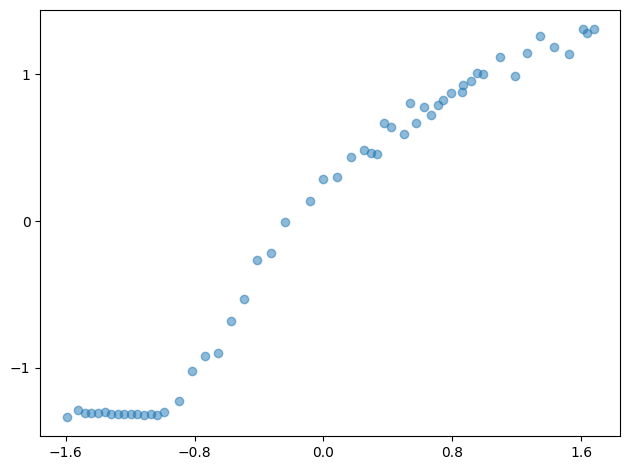

In [601]:
print(training_params, experiment_params)

rng = np.random.default_rng(experiment_params.seed)
keras.utils.set_random_seed(experiment_params.seed)

p3inn_dir = P3innDir(experiment_params.out_dir)

from sklearn.preprocessing import StandardScaler

try:
    # load from checkpoint
    if experiment_params.load_checkpoint:
        x_data = StandardScaler().fit_transform(
            preprocess_data(p3inn_dir.x_data.load())
        )
        y_data = StandardScaler().fit_transform(
            preprocess_data(p3inn_dir.y_data.load())
        )
    else:
        raise FileNotFoundError()
except FileNotFoundError:
    # load, shuffle and save
    x_data = StandardScaler().fit_transform(
        preprocess_data(np.load(experiment_params.x_data_path))
    )
    y_data = StandardScaler().fit_transform(
        preprocess_data(np.load(experiment_params.y_data_path))
    )
    shuffle_indices = np.arange(x_data.shape[0])
    rng.shuffle(shuffle_indices)
    x_data = x_data[shuffle_indices]
    y_data = y_data[shuffle_indices]
    p3inn_dir.x_data.save(x_data)
    p3inn_dir.y_data.save(y_data)

layer_sizes = (
    [x_data.shape[1]] + training_params.n_neurons_per_layer + [y_data.shape[1]]
)

if x_data.shape[1] == 1:
    x_eval = np.linspace(x_data.min(), x_data.max(), 1000).reshape(-1, 1)
else:
    x_eval = x_data.copy()  # TODO: Should be a grid
p3inn_dir.x_eval.save(x_eval)


plt.figure()
plt.scatter(x_data, y_data, alpha=0.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.savefig(p3inn_dir.image_dir / "input_data.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_49                │ (None, 1)              │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 1)              │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200 (804.00 B)

 Trainable params: 195 (780.00 B)

 Non-trainable params: 5 (24.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


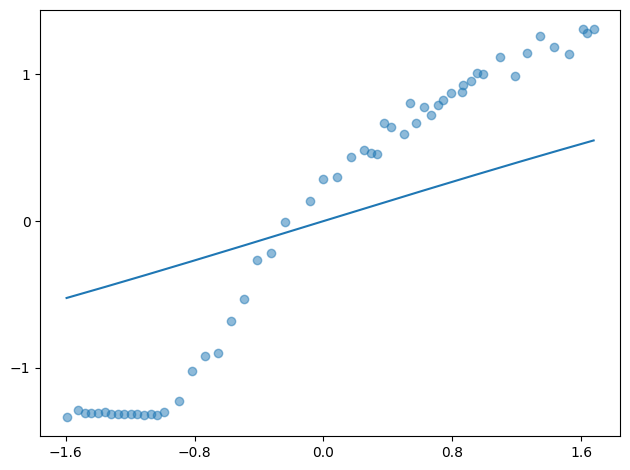

In [602]:
if passed_net_mean is None:
    if experiment_params.load_checkpoint and p3inn_dir.pred_mean.path.exists():
        # load checkpoint
        def mean_model(x):
            return np.interp(
                x.squeeze(), x_eval.squeeze(), p3inn_dir.pred_mean.load().squeeze()
            )

        mean_model = to_keras_model_proxy(mean_model)  # type: ignore
    else:
        normalizer = keras.layers.Normalization(axis=-1)
        normalizer.adapt(x_data)
        mean_model = make_model(
            layer_sizes,
            activation=training_params.activation_mean,
            normalizer=normalizer,
        )
        mean_model.summary()  # type: ignore
else:
    mean_model = to_keras_model_proxy(passed_net_mean)  # type: ignore


plt.figure()
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_eval, mean_model.predict(x_eval), "-")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.savefig(p3inn_dir.image_dir / "initial_mean_model.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

Epoch 1/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0643 - val_loss: 0.0520 - learning_rate: 0.1000
Epoch 2/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2151 - val_loss: 1.1943 - learning_rate: 0.1000
Epoch 3/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0764 - val_loss: 0.2125 - learning_rate: 0.1000
Epoch 4/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3099 - val_loss: 0.0920 - learning_rate: 0.1000
Epoch 5/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1123 - val_loss: 0.1604 - learning_rate: 0.1000
Epoch 6/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3238 - val_loss: 0.1196 - learning_rate: 0.1000
Epoch 7/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1444 - val_loss: 0.1735 - learning_rate: 0.1000
Epoch 8/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2506 - val_loss: 0.1214 - learning_rate: 0.1000
Epoch 9/20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1333 - val_loss: 0.1017 - learning_rate: 0.1000
Epoch 10/2

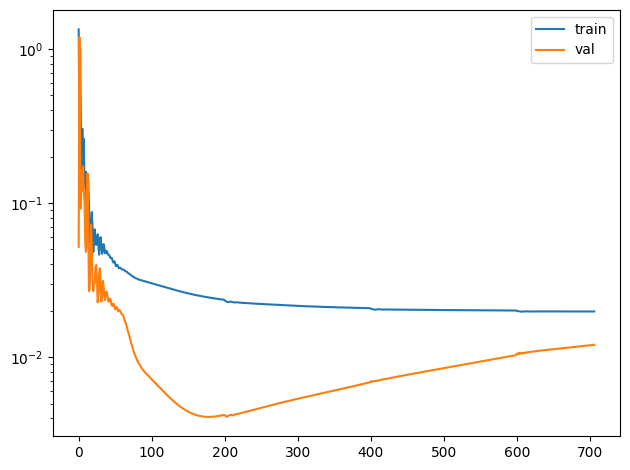

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


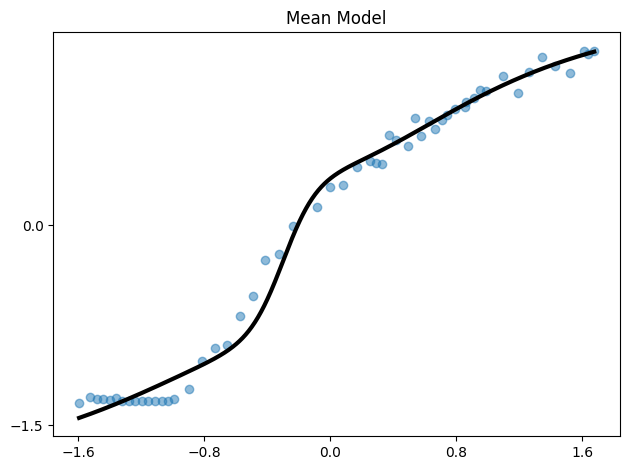

ValueError: 

In [603]:
mean_result = train_model(
    mean_model, x_data, y_data, x_eval, training_params, experiment_params, "mean"
)

mean_result.plot("Mean Model")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.savefig(p3inn_dir.image_dir / "transformed_data_split.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

In [604]:
!say "Done"
raise ValueError()


ValueError: 

median_shift=-0.0003339676042591966


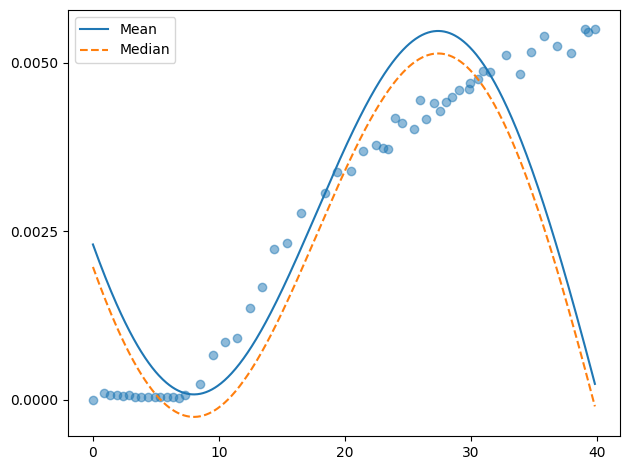

In [235]:
# Compute and split residuals
mean_residuals = y_data - mean_result.y_train_pred
median_shift = np.median(mean_residuals)
y_eval_pred_median = mean_result.y_eval_pred + median_shift
p3inn_dir.pred_median.save(y_eval_pred_median)

median_residuals = mean_residuals - median_shift
print(f"{median_shift=}")
pos_mask = median_residuals > 0
neg_mask = median_residuals < 0

assert (
    abs(np.count_nonzero(pos_mask) - np.count_nonzero(neg_mask)) <= 1
), "Residuals are not evenly split"

n_below = np.count_nonzero(
    y_data < np.interp(x_data, mean_result.x_eval.flat, y_eval_pred_median.flat)
)
n_above = np.count_nonzero(
    y_data > np.interp(x_data, mean_result.x_eval.flat, y_eval_pred_median.flat)
)

plt.figure()
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(mean_result.x_eval, mean_result.y_eval_pred, "-", label="Mean")
plt.plot(mean_result.x_eval, y_eval_pred_median, "--", label="Median")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.legend()
plt.savefig(p3inn_dir.image_dir / "learned_mean.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

In [236]:
assert (
    abs(n_below - n_above) <= 1
), f"Residuals are not evenly split: {abs(n_below - n_above)}"

std_models = {}
if (
    experiment_params.load_checkpoint
    and len(list(p3inn_dir.pred_PIs_dir.iterdir())) > 0
):
    median_eval = mean_result.y_eval_pred
    for q, bound_up, bound_down in p3inn_dir.iter_pred_PIs():
        if q < 0.8:
            continue
        bound_up = bound_up.squeeze()
        bound_down = bound_down.squeeze()
        print("Defining std funs from checkpoint", q)

        def net_up(x):
            y = np.interp(x.squeeze(), x_eval.squeeze(), bound_up - median_eval)
            return y.reshape(-1, 1)

        def net_down(x):
            y = np.interp(x.squeeze(), x_eval.squeeze(), median_eval - bound_down)
            return y.reshape(-1, 1)

        std_models["up"] = to_keras_model_proxy(net_up)
        std_models["down"] = to_keras_model_proxy(net_down)
        break

Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_67 (Sequential)      │ (None, 1)              │         4,357 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ square_42 (Square)              │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_42 (Add)                    │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sqrt_42 (Sqrt)                  │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,357 (17.02 KB)

 Trainable params: 4,355 (17.01 KB)

 Non-trainable params: 2 (8.00 B)

Epoch 1/1000


/Users/r/.venvs/p3inn/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_495. Received: the structure of inputs=['*']
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1725 - val_loss: 0.6306 - learning_rate: 1.0000e-05
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1722 - val_loss: 0.3285 - learning_rate: 1.0000e-05
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1719 - val_loss: 0.2077 - learning_rate: 1.0000e-05
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1716 - val_loss: 0.1450 - learning_rate: 1.0000e-05
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1713 - val_loss: 0.1077 - learning_rate: 1.0000e-05
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1710 - val_loss: 0.0835 - learning_rate: 1.0000e-05
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1707 - val_loss: 0.0670 - learning_rate: 1.0000e-05
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1705 - val_loss: 0.0552 - learning_rate: 1.0000e-05
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1702 - val_loss: 0.0466 - learning_rate: 1.0000e

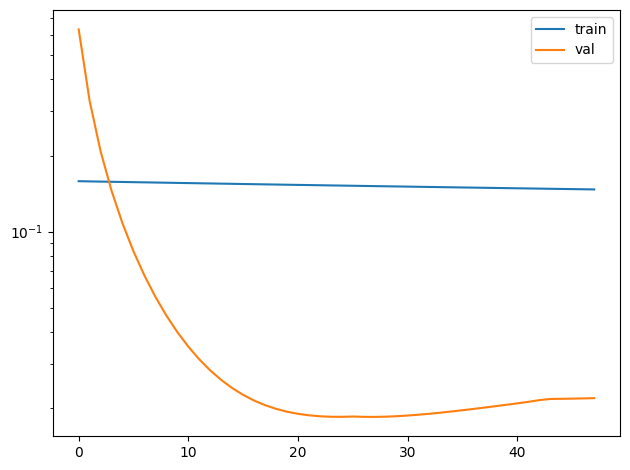

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


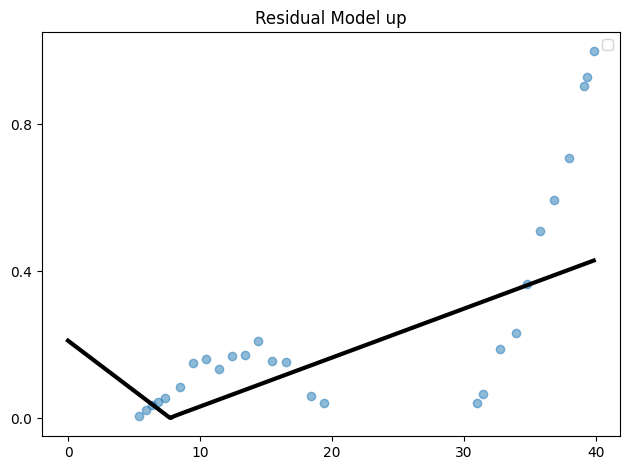

Model: "functional_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_68 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_68 (Sequential)      │ (None, 1)              │         4,357 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ square_43 (Square)              │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_43 (Add)                    │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sqrt_43 (Sqrt)                  │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,357 (17.02 KB)

 Trainable params: 4,355 (17.01 KB)

 Non-trainable params: 2 (8.00 B)

Epoch 1/1000


/Users/r/.venvs/p3inn/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_504. Received: the structure of inputs=['*']
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1218 - val_loss: 0.1030 - learning_rate: 1.0000e-05
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1214 - val_loss: 0.0637 - learning_rate: 1.0000e-05
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1211 - val_loss: 0.0512 - learning_rate: 1.0000e-05
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1207 - val_loss: 0.0460 - learning_rate: 1.0000e-05
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1203 - val_loss: 0.0436 - learning_rate: 1.0000e-05
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1200 - val_loss: 0.0425 - learning_rate: 1.0000e-05
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1196 - val_loss: 0.0421 - learning_rate: 1.0000e-05
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1192 - val_loss: 0.0420 - learning_rate: 1.0000e-05
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1189 - val_loss: 0.0410 - learning_rate: 1.0000e

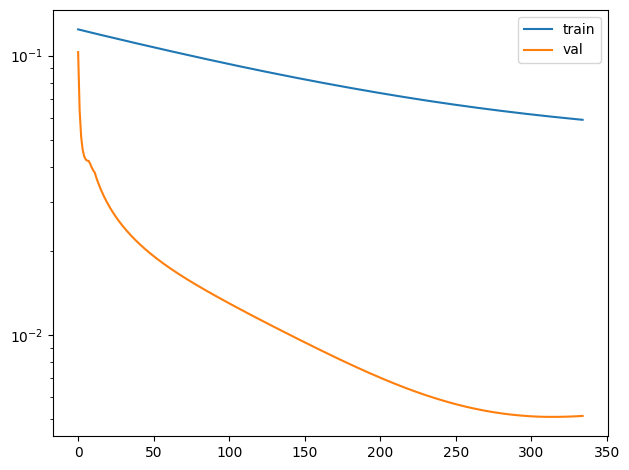

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


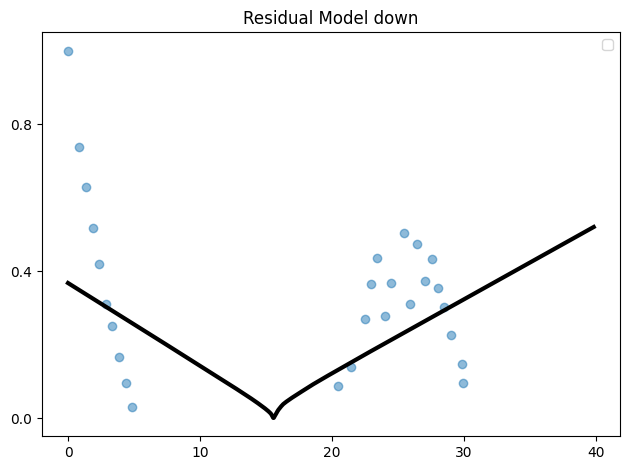

In [237]:
# Train residual models
residual_results = {}
for mask, sign, model_type in [(pos_mask, 1, "up"), (neg_mask, -1, "down")]:
    mask = np.squeeze(mask)
    x_data_res = x_data[mask, :]
    y_data_res = sign * median_residuals[mask, :]
    assert (y_data_res >= 0).all(), (y_data_res.min(), y_data_res.max())
    # TODO: scaling is needed but I would like to have it done by the model automatically.
    scale_factor = 1 / y_data_res.max()
    y_data_res *= scale_factor
    assert x_data_res.ndim == 2
    assert y_data_res.ndim == 2

    if len(std_models) == 0:
        model = make_model(
            layer_sizes,
            activation=training_params.activation_std,
            positivity_method=training_params.positivity_method,
        )
        model.summary()
    else:
        model = std_models[model_type]

    res_result = train_model(
        model, x_data_res, y_data_res, x_eval, training_params, experiment_params, "std"
    )
    assert (res_result.y_train_pred >= 0).all(), (
        res_result.y_train_pred.min(),
        res_result.y_train_pred.max(),
    )
    residual_results[model_type] = res_result

    residual_results[model_type].plot(f"Residual Model {model_type}")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
    plt.tight_layout()
    plt.legend()
    plt.savefig(p3inn_dir.image_dir / f"learned_residual_{model_type}.png")
    if not experiment_params.visualize:
        plt.close()
    else:
        plt.show(block=BLOCK)

PI contains 95%


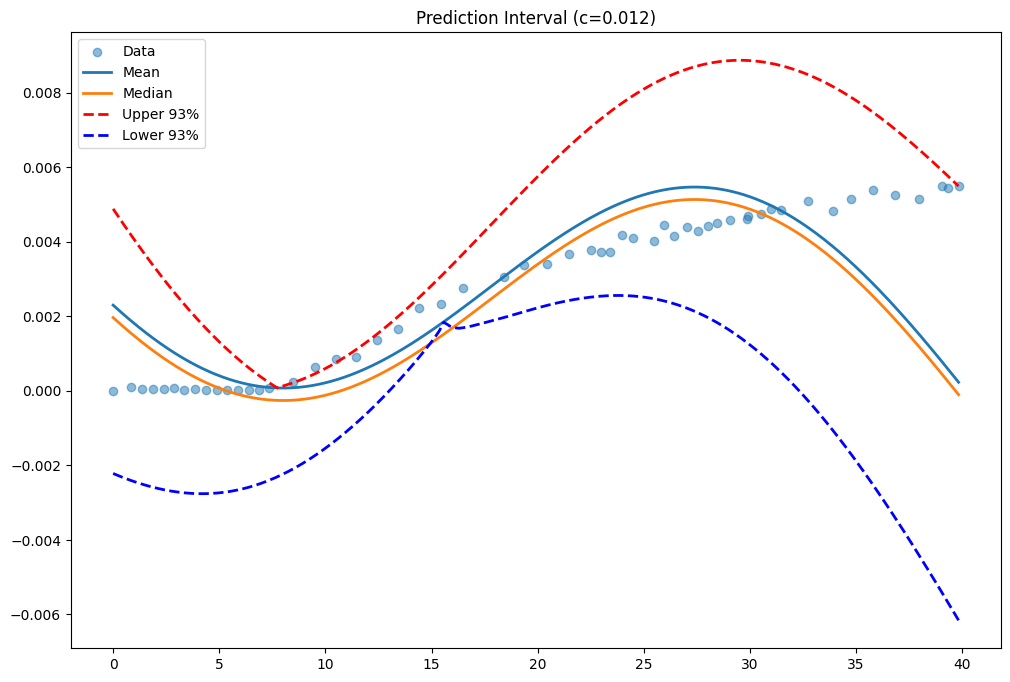

In [238]:
quantile = 0.93
# compute x% interval

upper_res_fulltrain = residual_results["up"].model(x_data)
lower_res_fulltrain = residual_results["down"].model(x_data)


def objective(c):
    upper = mean_result.y_train_pred + c * upper_res_fulltrain
    lower = mean_result.y_train_pred - c * lower_res_fulltrain
    return np.mean((y_data >= lower) & (y_data <= upper)) - quantile


c = optimize.bisect(objective, 0, 10)

upper_bound = (
    mean_result.y_eval_pred + c * residual_results["up"].y_eval_pred
).squeeze()
lower_bound = (
    mean_result.y_eval_pred - c * residual_results["down"].y_eval_pred
).squeeze()

x_eval = mean_result.x_eval.squeeze()
n_inside = np.count_nonzero(
    (y_data < np.interp(x_data, x_eval, upper_bound))
    & (y_data > np.interp(x_data, x_eval, lower_bound))
)
print(f"PI contains {n_inside / x_data.shape[0]:.0%}")

# Plot final result
plt.figure(figsize=(12, 8))
plt.title(f"Prediction Interval (c={c:.3f})")
plt.scatter(x_data, y_data, alpha=0.5, label="Data")
plt.plot(mean_result.x_eval, mean_result.y_eval_pred, "-", lw=2, label="Mean")
plt.plot(mean_result.x_eval, y_eval_pred_median, "-", lw=2, label="Median")
plt.plot(x_eval, upper_bound, "r--", lw=2, label=f"Upper {quantile:.0%}")
plt.plot(x_eval, lower_bound, "b--", lw=2, label=f"Lower {quantile:.0%}")
plt.legend()
plt.show()

# TODO:
# - hyperparam optimization
